In [1]:
"""
Optimization Networks Example

The idea is to build optimization networks and structures in a similar fashion to
networks used in machine learning for fitting tasks, etc.
"""
import qutree
import importlib

import qutree.optimization
importlib.reload(qutree)
importlib.reload(qutree.optimization)

from qutree import Grid, Objective
import numpy as np
from qutree.optimization import Model, variation_update, recombination_update, evaluate_grid
from qutree.optimization import create_mutations, recombination, maxvol_selection
import random


def V(x):
    N = x.shape[0]
    v = 0.
    for i in range(N):
        v += 0.5*(x[i]+1.5)**2 + x[i]*x[(i+1) % N]
    return v


def pot(x):
    v = 0.
    for i in range(0, x.shape[0]):
        v += np.sin(np.pi*x[i]**2)/(x[i]**2+1e-7)
    for i in range(0, x.shape[0]):
        v+=np.sin(x[i]*x[i-1])
    return v - 15.


def rosenbrock_function(x):
    return np.sum(100. * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)


N, r, f, nsweep = 21, 3, 4, 5
# fun = ttopt_functions.brown
# fun = pot
fun = rosenbrock_function

xs = np.array([[-0.5, -0.5, -0.5, -0.5],
               [-1.5, -1.5,  1.5, -1.5],
               [ 0.0,  0.0,  0.0,  0.0]])


# xs = np.array([[0.5, 0.9, 0.8, 0.1],
#                [0.0, 0.0, 0.8, 0.8],
#                [0.1, 0.1, 0.2, 0.3],
#                [0.2, 0.3, 0.5, 0.5]])


primitive_grid = []
for k in range(f):
    primitive_grid.append(Grid(np.linspace(0., 1., N, endpoint=True), [k]))
    # primitive_grid.append(Grid(np.linspace(-4., 4., N), [k]))


def random_points(primitive_grid, r):
    x = []
    for grid in primitive_grid:
        g = grid.grid.reshape(-1)

        subset = random.sample(list(g), r)
        x.append(subset)
    x = np.array(x).T
    return x


class SeparableModel(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            grid, _ = variation_update(grid, self.primitive_grid[k], function, self.r, epoch = epoch)

        return grid, None


class StandardModel(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            if k > 0:
                idcs = list(range(k))
                ngrid = recombination(grid, idcs)
                grid, _ = recombination_update(grid, idcs, function, r, epoch = epoch)
            # grid, _ = variation_update(grid, self.primitive_grid[k], function, r, epoch=epoch)

        return grid, None


fmin_mt = []
npoints_mt = []
for i in range(1):
    obj = Objective(fun)
    # model = SeparableModel()
    model = StandardModel()

    xs = random_points(primitive_grid, r)
    grid = Grid(xs, [0, 1, 2, 3])

    model.data(primitive_grid, r)
    grid = model.optimize(grid, obj, nsweep)
    vs = np.array([v for v in obj.cache.values()])
    # print(grid)
    fmin_mt.append(np.min(vs))
    npoints_mt.append(len(obj.cache))

    # print(obj)
    # print(obj.logger.df)

print(npoints_mt)
print(np.mean(npoints_mt))
print(fmin_mt)
print(np.mean(fmin_mt))

[21]
21.0
[np.float64(7.301250000000001)]
7.301250000000001


In [2]:
print(npoints_mt)
print(np.mean(npoints_mt))
print(fmin_mt)
print(np.mean(fmin_mt))

[21]
21.0
[np.float64(7.301250000000001)]
7.301250000000001


In [3]:
print(npoints_mt)
print(np.mean(npoints_mt))
print(fmin_mt)
print(np.mean(fmin_mt))

[21]
21.0
[np.float64(7.301250000000001)]
7.301250000000001


In [4]:

class TTOpt(Model):

    def data(self, primitive_grid, r):
        self.primitive_grid = primitive_grid
        self.r = r

    def sweep(self, grid, function, epoch):
        for k in range(f):
            grid = create_mutations(grid, self.primitive_grid[k])
            if k > 0:
                idcs = list(range(k))
                ngrid = recombination_update(grid, idcs)
            ngrid, _ = maxvol_selection(ngrid, function, grid.num_points(), epoch = epoch)



[np.float64(0.2712499999999995), np.float64(0.2512499999999999), np.float64(0.6731250000000005), np.float64(0.0731249999999998), np.float64(0.24999999999999936), np.float64(0.0), np.float64(0.6512500000000006), np.float64(0.24625000000000058), np.float64(0.0), np.float64(0.2531249999999994)]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21]


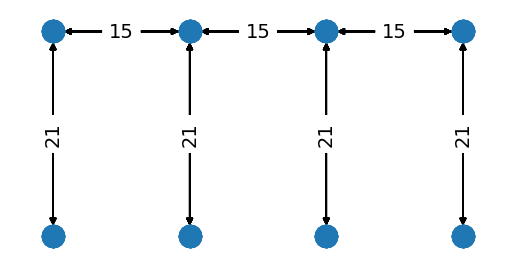

In [5]:
"""
Minimal example: optimize 3D V(x) with tensor train.
See next cell for balanced tree and how to provide starting points.
"""
from qutree import *

def V(x):
    # p = [1, 2, 3, ...]
    point = np.array(list(range(x.shape[0])))
    return np.sum((x-point)**2)

fmin_tt = []
npoints_tt = []
for i in range(10):
    # objective = Objective(V)
    objective = Objective(rosenbrock_function)

    N, r, f, nsweeps, seed = 21, 15, 4, 3, 238141

    # --- Pick a network structure: ---
    G = tensor_train_graph(f, r, N)
    fig = plot_tt_diagram(G)
    # G = balanced_tree(f, r, N)
    # fig = plot_tree(G)

    # boundaries of primitive grid
    primitive_grid = [np.linspace(0., 1., num = N)] * f

    G_opt = ttnopt(G, objective, nsweeps, primitive_grid)

    # Display output (can vary with random parameters)
    vs = np.array([v for v in objective.cache.values()])
    fmin_tt.append(np.min(vs))
    npoints_tt.append(len(obj.cache))
    # print(np.min(vs))
    # print(objective.logger.df['f'].min())
    # print(objective)
    # display(objective.logger.df)

print(fmin_tt)
print(npoints_tt)

In [6]:
print(npoints_tt)
print(np.mean(npoints_tt))
print(fmin_tt)
print(np.mean(fmin_tt))

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
21.0
[np.float64(0.2712499999999995), np.float64(0.2512499999999999), np.float64(0.6731250000000005), np.float64(0.0731249999999998), np.float64(0.24999999999999936), np.float64(0.0), np.float64(0.6512500000000006), np.float64(0.24625000000000058), np.float64(0.0), np.float64(0.2531249999999994)]
0.26693749999999994
